<p style="color:#8D3DAF"><big><strong>Importing required libraries</strong></big></p>

In [1]:
## importing required libraries

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

import random, os, pickle, cv2, warnings
import math

warnings.filterwarnings('ignore')
random.seed(23)

<p style="color:#8D3DAF"><big><strong>Getting the content and style image paths</strong></big></p>

In [2]:
## getting the content and style image paths

style_img_path = "./Images/Style_Image.jpeg"
content_img_path = "./Images/Content_Image.jpeg"

<p style="color:#8D3DAF"><big><strong>Loading the pretrained VGG19 model</strong></big></p>

In [3]:
## loading pretrained vgg19 model

model = VGG19(include_top=False, weights='imagenet')
model.trainable = False

## getting the model summary
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<p style="color:#8D3DAF"><big><strong>Creating functions to preprocess, deprocess and display images</strong></big></p>

<p style="color:#8D3DAF">Now, let's load the images and then preprocess them using the <strong>preprocess_input</strong> function in VGG19. preprocess_input() function converts the input RGB images into BGR images and center these values around 0 according to ImageNet data. Also let's add another dimension to the image to represent number of images in input.</p>

In [4]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path)
    ## converting image to an array
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

<p style="color:#8D3DAF">Let's define a function which will deprocess the processed images (which are processed using vgg19 preprocess_input function). Also, let's define another function which will be used to display any unprocessed images.</p>

In [5]:
def deprocess(img):
    ## performing the inverse of the preprocessing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.799
    img[:, :, 2] += 123.68
    
    ## converting images from BGR to RGB
    img = img[:, :, ::-1]
    
    ## restricting the values for image array between 0 and 255 and then converting the datatype to 'uint8'
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [6]:
def display_img(img):
    ## removing extra dimension
    if len(img.shape) == 4:
        img = np.squeeze(img, axis=0)
    
    img = deprocess(img)
    
    plt.grid(False)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    return

<p style="color:#8D3DAF"><big><strong>Displaying a content and a style image</strong></big></p>

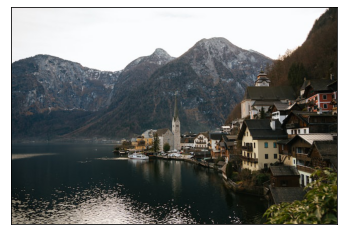

In [7]:
content_image = load_and_preprocess_image(content_img_path)
display_img(content_image)

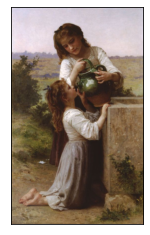

In [8]:
style_image = load_and_preprocess_image(style_img_path)
display_img(style_image)

<p style="color:#8D3DAF"><big><strong>Creating a model to find out the feature map of content image</strong></big></p>

<p style="color:#8D3DAF">Let's create a model which will help us to find the feature map required to find the loss. Since we want the general idea of how the image content is laid out, we will use the deeper layer for content model. Let's use the <strong>block5_conv2</strong> convolutional layer of vgg19 as our final layer for this model.</p>

In [9]:
content_layer = 'block5_conv2'

content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)

## finding the summary of the content_model
content_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<p style="color:#8D3DAF"><big><strong>Creating multiple models to find the feature map of style image</strong></big></p>

<p style="color:#8D3DAF">Let's create a model for style image. We do not know the exact location of the layer which will give us the something that we call style of the image. So, in order to deal with this situation we will create mulitple models with different layers as output.</p>

In [10]:
style_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

style_models = [Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers]

In [11]:
## finding the summary of different style models

for index, model in enumerate(style_models):
    print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________
None
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None,

None


<p style="color:#8D3DAF"><big><strong>Defining the function to find out the content loss</strong></big></p>

<p style="color:#8D3DAF">The content loss is found out by taking the <strong>mean square difference</strong> between the feature maps of content image and the generated image.</p>

In [12]:
def content_cost(content_img_arr, generated_img_arr):
    ## a_C and a_G represent the feature maps for the content and generated images
    a_C = content_model(content_img_arr)
    a_G = content_model(generated_img_arr)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

<p style="color:#8D3DAF"><big><strong>Defining the function to find out the style loss</strong></big></p>

<p style="color:#8D3DAF">The first step to find out style loss is to find out the gram matrix. Then we will find out the style loss as the weighted sum of loss of each of the style models. The loss of each of the style model is calculated by taking the mean square difference of gram matrices of style image and generated image for that model.</p>

In [13]:
def gram_matrix(A):
    # A represent the feature map of image over some model
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    coeff = 1 / tf.cast(n, tf.float32)
    return gram*coeff

In [14]:
## finding the weight for weighted sum of style losses. Let's take the equal weight for each of the model

weight_for_each_model = 1. / len(style_models)

def style_cost(style_img_arr, generated_img_arr):
    
    Total_loss = 0
    
    for style_model in style_models:
        a_S = style_model(style_img_arr)
        a_G =style_model(generated_img_arr)
        
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        
        loss = tf.reduce_mean(tf.square(GS - GG))
        Total_loss += loss * weight_for_each_model
        
    return Total_loss

<p style="color:#8D3DAF"><big><strong>Defining the function for training</strong></big></p>

<p style="color:#8D3DAF">Steps to create a function for training:</p>

<ol style="color:#8D3DAF">
    <li>Getting the array representation of content and style images</li>
    <li>Initializing the generated image array randomly</li>
    <li>Getting the optimizer object</li>
    <li>For every iteration perform:
        <ol>
            <li>Finding the content loss, style loss and the total loss</li>
            <li>Finding the gradient of total loss with respect to the generated image array</li>
            <li>Updating the elements of generated image array</li>
        </ol>
    </li>
    <li>At the end of all iterations, we will get our final generated image</li>
</ol>

In [15]:
generated_images = []

def training_function(content_path, style_path, iterations=50, content_loss_coeff=10, style_loss_coeff=100):
    ## loading the content and style image
    content = load_and_preprocess_image(content_path)
    style = load_and_preprocess_image(style_path)
    ## initializing the generated image using content image array
    generated = tf.Variable(content, dtype=tf.float32)
    
    ## getting optimizer object (let's use adam optimizer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5)
    
    best_loss = math.inf
    best_image = None
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            content_loss = content_cost(content,generated)
            style_loss = style_cost(style, generated)
            total_loss = content_loss_coeff * content_loss + style_loss_coeff * style_loss
            
        ## finding the gradient of total_loss with respect to the generated image array
        gradients = tape.gradient(total_loss, generated)
        
        ## updating the generated image array with the gradients calculated earlier
        optimizer.apply_gradients(zip([gradients], [generated]))
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_image = generated.numpy()
            
        print(f"Iteration: {i}")
        print(f"Total loss: {total_loss}")
        
        generated_images.append(generated)
    
    return best_image

<p style="color:#8D3DAF"><big><strong>Starting training...</strong></big></p>

In [16]:
training_function(content_img_path, style_img_path)

Iteration: 0
Total loss: 795253276672.0
Iteration: 1
Total loss: 390159138816.0
Iteration: 2
Total loss: 280737054720.0
Iteration: 3
Total loss: 225862418432.0
Iteration: 4
Total loss: 195455107072.0
Iteration: 5
Total loss: 174750187520.0
Iteration: 6
Total loss: 157754769408.0
Iteration: 7
Total loss: 142957756416.0
Iteration: 8
Total loss: 129800462336.0
Iteration: 9
Total loss: 117951938560.0
Iteration: 10
Total loss: 107230265344.0
Iteration: 11
Total loss: 97570512896.0
Iteration: 12
Total loss: 88842715136.0
Iteration: 13
Total loss: 80919322624.0
Iteration: 14
Total loss: 73759260672.0
Iteration: 15
Total loss: 67256766464.0
Iteration: 16
Total loss: 61327740928.0
Iteration: 17
Total loss: 55910690816.0
Iteration: 18
Total loss: 50962542592.0
Iteration: 19
Total loss: 46442921984.0
Iteration: 20
Total loss: 42370424832.0
Iteration: 21
Total loss: 38711349248.0
Iteration: 22
Total loss: 35389505536.0
Iteration: 23
Total loss: 32395806720.0
Iteration: 24
Total loss: 29696661504.0

array([[[[ 1.41414215e+02,  1.03327400e+02,  1.23598969e+02],
         [ 6.08292847e+01,  7.46735077e+01,  6.32745705e+01],
         [ 1.15942276e+02,  1.01766502e+02,  1.21344788e+02],
         ...,
         [-7.91527176e+01, -6.41747971e+01, -5.77081757e+01],
         [-7.58341293e+01, -5.37273598e+01, -5.49974556e+01],
         [-1.07078232e+02, -7.69673843e+01, -8.29342728e+01]],

        [[ 9.99184723e+01,  9.12576065e+01,  8.74817429e+01],
         [ 1.00272881e+02,  9.07211685e+01,  8.67398834e+01],
         [ 1.05781944e+02,  9.79368134e+01,  9.57052994e+01],
         ...,
         [-8.84333649e+01, -7.40596085e+01, -4.52827187e+01],
         [-8.21312714e+01, -5.97408829e+01, -5.40100060e+01],
         [-7.50125885e+01, -5.03862877e+01, -4.54688225e+01]],

        [[ 1.21506363e+02,  9.93132324e+01,  1.06225983e+02],
         [ 8.17183914e+01,  8.56637421e+01,  8.12230225e+01],
         [ 1.10970703e+02,  1.07512718e+02,  1.08000313e+02],
         ...,
         [-7.51635284e+0

<p style="color:#8D3DAF"><big><strong>Displaying generated images...</strong></big></p>

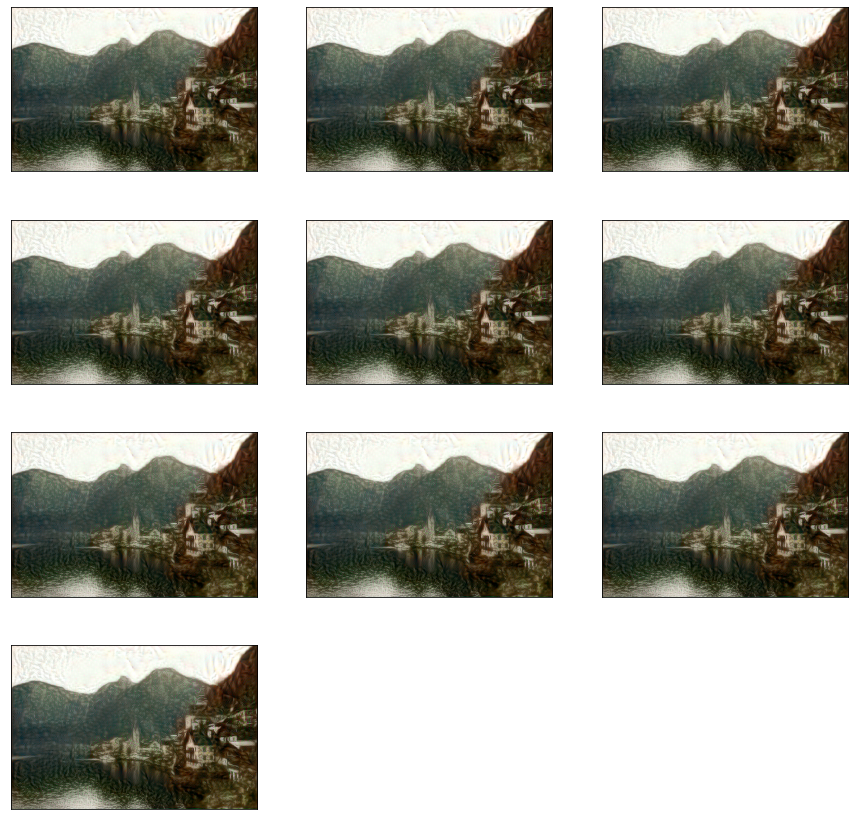

Best image found after 50 iterations:


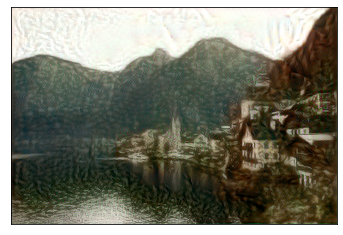

In [17]:
## we will display last 11 generated images
plt.figure(figsize=(15,15))

for index in range(10):
    plt.subplot(4,3, index+1)
    display_img(generated_images[index+39])
plt.show()

print("Best image found after 50 iterations:")
display_img(generated_images[-1])